In [1]:
time_start = dt.now()

### Functions

In [2]:
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mse': metrics.mean_squared_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
    }

### 1. Prepare dataset

In [3]:
# read train dataset
df1 = pd.read_csv('data/train.csv')
df1['row_id'] = range(len(df1))

# read test dataset
df2 = pd.read_csv('data/new/test.csv')
df2['row_id'] = range(len(df2))
df2['row_id'] = df2['row_id']  + 1000000

# merge
df = pd.concat([df1,df2])
del df1,df2
gc.collect()

# add fold for splitting
np.random.seed(1234)
df['fold'] = np.random.randint(0,3,len(df))
# drop some features
feats_drop = ['timestamp','active_power_calculated_by_converter','reactice_power_calculated_by_converter']
for f in feats_drop:
    if f in df.columns:
        del df[f]
# label encoder of categorical feats
feats_cat = ['turbine_id']
list_lbl  = []
for f in feats_cat:
    lbl = preprocessing.LabelEncoder()
    df[f] = lbl.fit_transform(df[f])
    list_lbl.append(lbl)

In [4]:
feats_used = [        
    "active_power_raw",
    "ambient_temperature",
    "generator_speed",
    "generator_winding_temp_max",
    "grid_power10min_average",
    "nc1_inside_temp",
    "nacelle_temp",
    "reactive_power",
    "wind_direction_raw",
    "wind_speed_raw",
    "wind_speed_turbulence",
  
]

### 2. Training

In [5]:
# Sets creation
feat_target = 'Target'

filt_fold  = df.fold == 0
filt_null  = df[feat_target].isnull()

filt_train = ~filt_fold & ~filt_null
filt_valid = filt_fold & ~filt_null
filt_test  = filt_null

x, y   = df[filt_train][feats_used], df[filt_train][feat_target]
xv, yv = df[filt_valid][feats_used], df[filt_valid][feat_target]
xt, yt = df[filt_test][feats_used],  df[filt_test][feat_target]

print(x.shape, xv.shape, xt.shape)

del df
gc.collect()
x[:3]

(606820, 11) (302784, 11) (303202, 11)


,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence
0,834.92,31.69,"1,159.62",65.95,917.90,31.88,31.50,165.50,280.86,7.06,0.54
1,421.05,12.89,928.75,59.57,445.55,32.42,32.76,113.84,299.55,5.47,0.47
5,620.64,28.06,955.60,60.88,697.72,31.01,31.05,75.78,229.57,6.03,0.78


In [6]:
scaler = preprocessing.StandardScaler()

scaler.fit(x)
x1 = scaler.transform(x)
xv1 = scaler.transform(xv)
xt1 = scaler.transform(xt)

In [7]:
from keras import layers
from keras import models
from keras import Input
from tensorflow.keras import applications

# 1) MLP
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=11))
model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='linear'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5

In [8]:
######################################
# Keras pipeline
######################################

from keras import optimizers
from keras import losses
from keras import metrics
from keras import callbacks

# 1) create input data and generators
# 2) define model

# 3) define callbacks
# shutil.rmtree('logs')
# os.mkdir('logs')
# tensorboard --logdir=logs --port=6007

callbacks_list = [ 
    callbacks.EarlyStopping(monitor='val_mape', min_delta=1e-15, patience=500, restore_best_weights=True),
    # callbacks.ModelCheckpoint(filepath=f'models/all.h5', monitor='val_mape', mode='max', save_best_only=True),
    # callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
    # callbacks.TensorBoard(log_dir=f'logs/{turb}')#, histogram_freq=1, embeddings_freq=1)
]

# 4) compile model
model.compile(
    optimizer = optimizers.rmsprop_v2.RMSprop(lr=0.001),
    loss      = losses.mse,
    metrics   = ['mae','mape']
)
    

# 5) train model
history = model.fit(
    x1,
    y,
    epochs = 2000,
    validation_data=(xv1, yv),
    batch_size = 1024,
    verbose=1,
    # validation_split = 0.2,
    callbacks = callbacks_list    
)

Epoch 1/2000
593/593 [==============================] - 2s 3ms/step - loss: 149.3885 - mae: 6.4576 - mape: 13.9234 - val_loss: 8.0627 - val_mae: 2.2520 - val_mape: 4.9145
Epoch 2/2000
593/593 [==============================] - 2s 3ms/step - loss: 5.5706 - mae: 1.7855 - mape: 3.8334 - val_loss: 7.0899 - val_mae: 2.0685 - val_mape: 4.3707
Epoch 3/2000
593/593 [==============================] - 2s 3ms/step - loss: 5.0004 - mae: 1.6807 - mape: 3.6068 - val_loss: 5.6699 - val_mae: 1.9217 - val_mape: 4.2001
Epoch 4/2000
593/593 [==============================] - 2s 3ms/step - loss: 4.7920 - mae: 1.6437 - mape: 3.5271 - val_loss: 5.8328 - val_mae: 1.8596 - val_mape: 3.9268
Epoch 5/2000
593/593 [==============================] - 2s 3ms/step - loss: 4.6345 - mae: 1.6134 - mape: 3.4624 - val_loss: 5.0367 - val_mae: 1.7824 - val_mape: 3.9015
Epoch 6/2000
593/593 [==============================] - 2s 3ms/step - loss: 4.5188 - mae: 1.5910 - mape: 3.4148 - val_loss: 4.3280 - val_mae: 1.5307 - val_ma

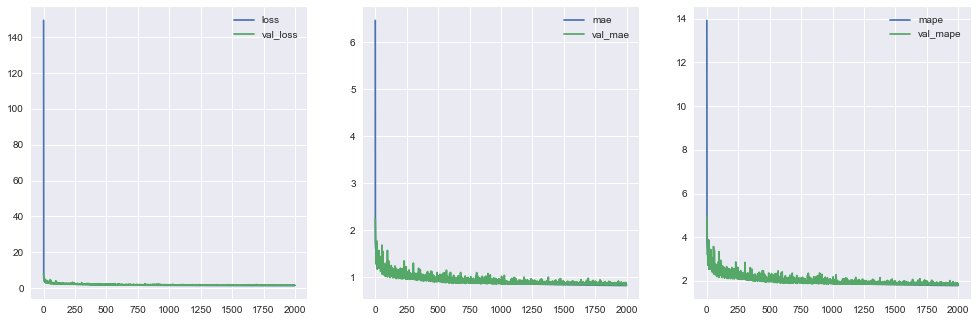

In [9]:
# 6) plotting
plt.style.use('seaborn')
df_out = pd.DataFrame(history.history)
_,ax = plt.subplots(1,3,figsize = (15,5))
p = df_out.iloc[:,[0,3]].plot(ax = ax[0])
p = df_out.iloc[:,[1,4]].plot(ax = ax[1])
p = df_out.iloc[:,[2,5]].plot(ax = ax[2])

In [10]:
pred = model.predict(xv1)[:,0]
ts_metrics(yv, pred)

{'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.8528249>,
 'mse': <tf.Tensor: shape=(), dtype=float32, numpy=1.5406677>,
 'mape': 0.01841694727090267,
 'smape': 0.018335720861476758}

In [11]:
# predictions
df_out = pd.DataFrame({
    'Target': pred
})
df_out.to_csv('output/valid_mlp.csv', index = False, sep = ',')

df_out = pd.DataFrame({
    'Target': model.predict(xt1)[:,0]
})
df_out.to_csv('output/main_mlp.csv', index = False, sep = ',')

In [12]:
print('Working time: ', dt.now() - time_start) 

Working time:  0:56:03.063011
